In [ ]:
import pandas as pd
# 1. Load the data
data = pd.read_csv("/content/drive/MyDrive/Mutual_Fund_Data_Forecasting/UTI_Gold_ETF_MF_USD_01012023_31122024_ALL.csv")
data['All_Date'] = pd.to_datetime(data['All_Date'], format='%m-%d-%Y')
data.sort_values("All_Date", inplace=True)
print(data.head())
print(data.tail())
print("Shape:", data.shape)

    All_Date   MF_NAV  ETF_Price  ETF_Open  ETF_High  ETF_Low  ETF_Vol  \
0 2023-01-02  10.8613      47.20     46.85     47.65    46.65   71.20K   
1 2023-01-03  10.9525      47.60     47.85     47.85    47.35  133.23K   
2 2023-01-04  11.0553      48.05     47.65     48.10    47.50  119.40K   
3 2023-01-05  10.9910      47.80     48.00     48.05    47.70   53.18K   
4 2023-01-06  10.9449      47.60     48.10     48.10    47.45   90.70K   

  ETF_Change  USD_Price  USD_Open  USD_High  USD_Low USD_Change    Gold_Open  \
0      0.53%     82.745    82.670    82.800   82.560      0.03%          NaN   
1      0.85%     82.774    82.698    83.038   82.654      0.04%  1836.199951   
2      0.95%     82.641    82.779    82.919   82.667     -0.16%  1845.599976   
3     -0.52%     82.568    82.740    82.808   82.426     -0.09%  1855.199951   
4     -0.42%     82.270    82.604    82.785   82.275     -0.36%  1838.400024   

     Gold_High     Gold_Low   Gold_Close  Gold_Volume  
0          NaN    

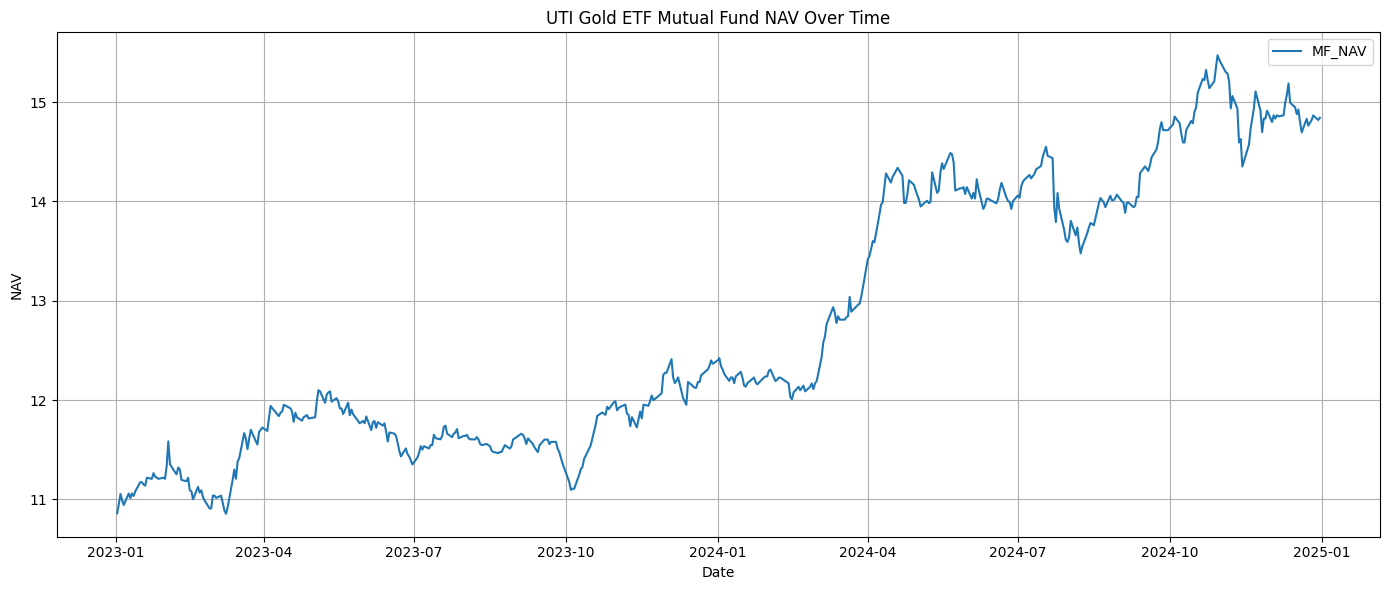

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the original MF_NAV time series
plt.figure(figsize=(14, 6))
sns.lineplot(data=data, x=data['All_Date'], y='MF_NAV', label='MF_NAV')
plt.title("UTI Gold ETF Mutual Fund NAV Over Time")
plt.xlabel("Date")
plt.ylabel("NAV")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# Step 2: Clean ETF_Change % and USD_Change % (remove '%' and convert to float)
data['ETF_Change'] = data['ETF_Change'].str.replace('%', '', regex=False).astype(float)
data['USD_Change'] = data['USD_Change'].str.replace('%', '', regex=False).astype(float)

# Step 3: Convert ETF_Vol. from strings like '71.20K', '6.13M' to floats
def convert_volume(val):
    if isinstance(val, str):
        val = val.strip()
        if val.endswith('K'):
            return float(val.replace('K', '')) * 1_000
        elif val.endswith('M'):
            return float(val.replace('M', '')) * 1_000_000
    try:
        return float(val)
    except:
        return None

data['ETF_Vol'] = data['ETF_Vol'].apply(convert_volume)

# Step 4: Convert all numeric columns to float
numeric_columns = [
    'MF_NAV', 'ETF_Price', 'ETF_Open', 'ETF_High', 'ETF_Low',
    'USD_Price', 'USD_Open', 'USD_High', 'USD_Low',
    'Gold_Open', 'Gold_High', 'Gold_Low', 'Gold_Close',
    'Gold_Volume'
]

data[numeric_columns] = data[numeric_columns].astype(float)

# Step 5: Check for missing values
missing_summary = data.isna().sum()
missing_summary[missing_summary > 0]


,0
Gold_Open,16
Gold_High,16
Gold_Low,16
Gold_Close,16
Gold_Volume,16


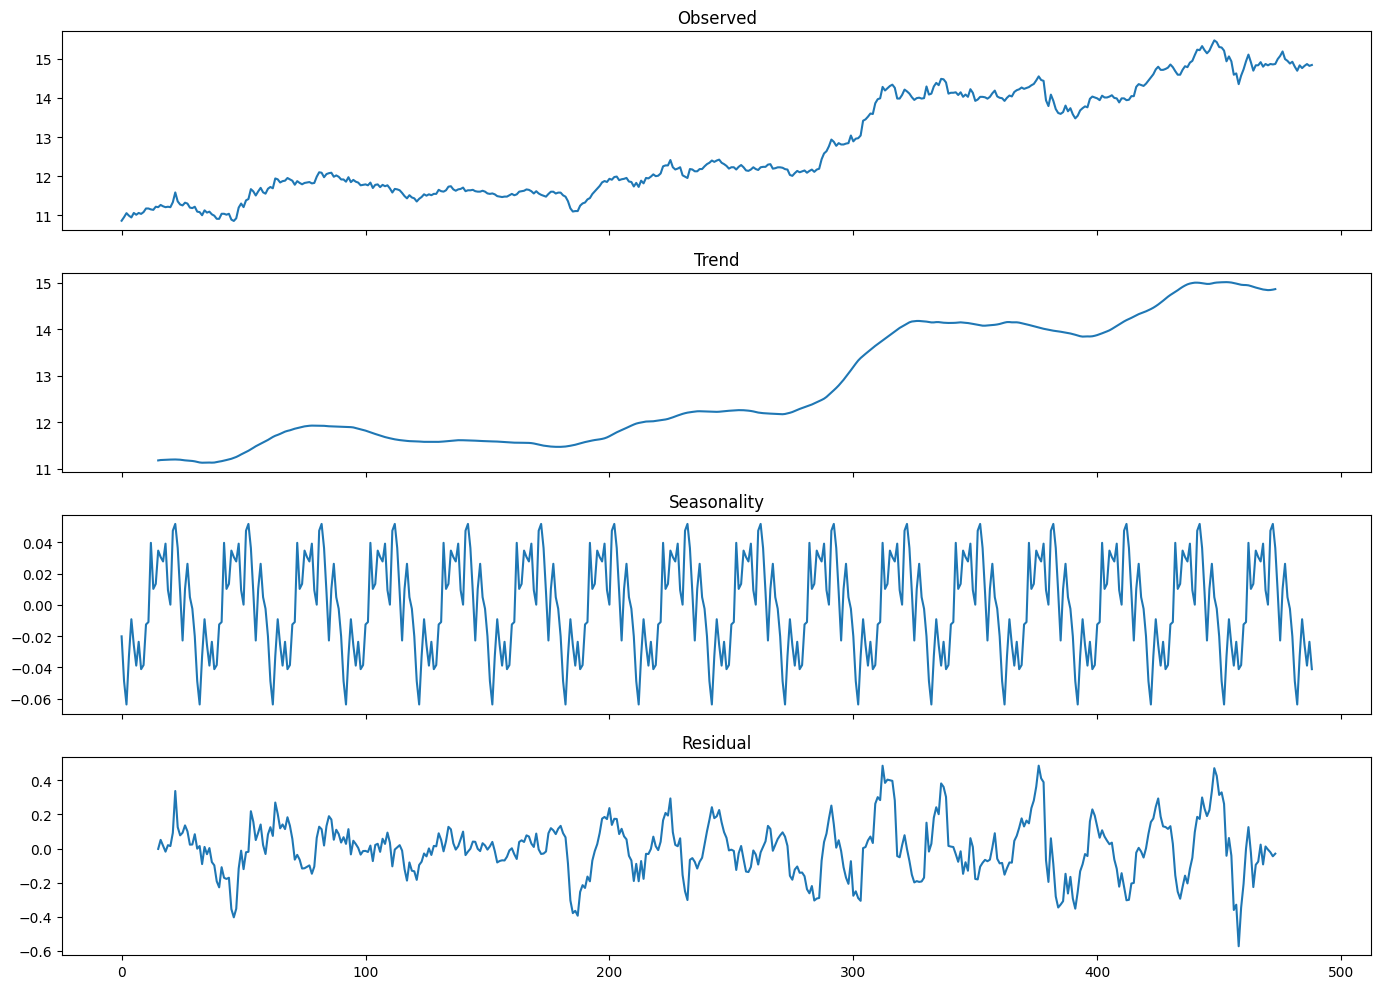

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition (using additive model)
result = seasonal_decompose(data['MF_NAV'], model='additive', period=30)  # Approx monthly seasonality

# Plot the decomposition
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
result.observed.plot(ax=axs[0], title='Observed')
result.trend.plot(ax=axs[1], title='Trend')
result.seasonal.plot(ax=axs[2], title='Seasonality')
result.resid.plot(ax=axs[3], title='Residual')
plt.tight_layout()
plt.show()

In [ ]:
print("Missing values per column before kalman smoothing")
print(data.isna().sum())

Missing values per column before kalman smoothing
All_Date        0
MF_NAV          0
ETF_Price       0
ETF_Open        0
ETF_High        0
ETF_Low         0
ETF_Vol         0
ETF_Change      0
USD_Price       0
USD_Open        0
USD_High        0
USD_Low         0
USD_Change      0
Gold_Open      16
Gold_High      16
Gold_Low       16
Gold_Close     16
Gold_Volume    16
dtype: int64


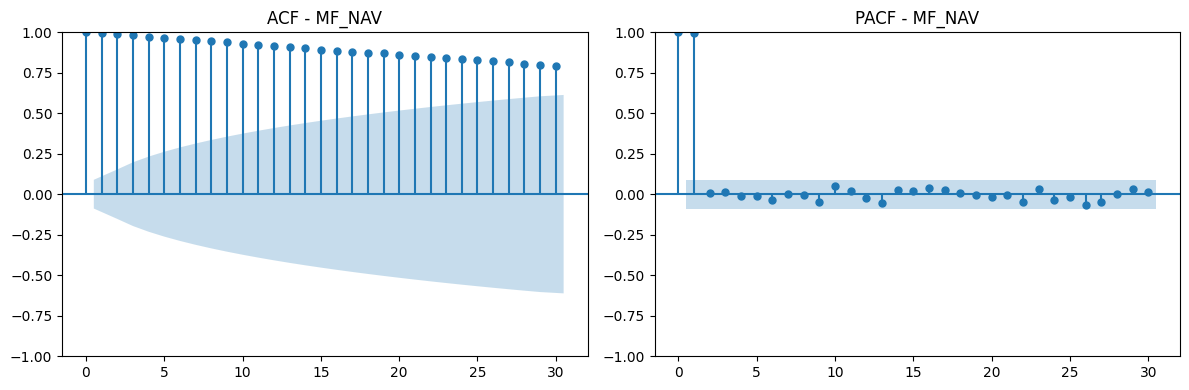

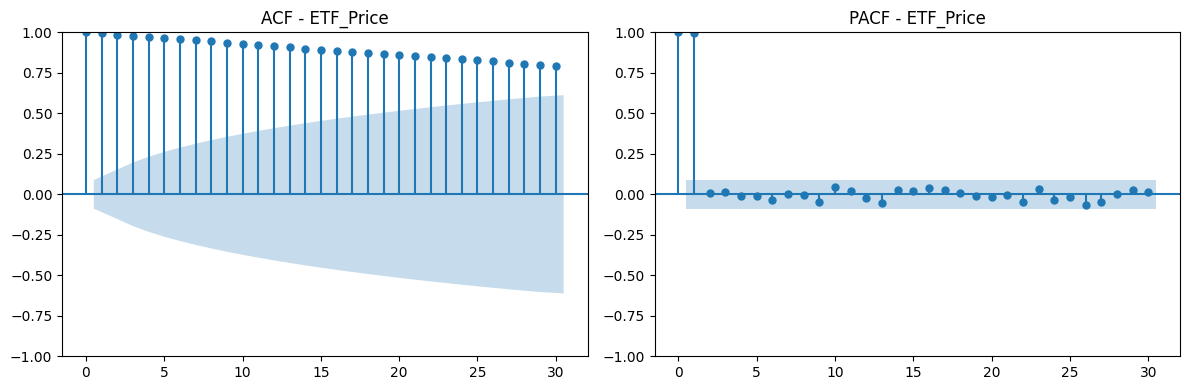

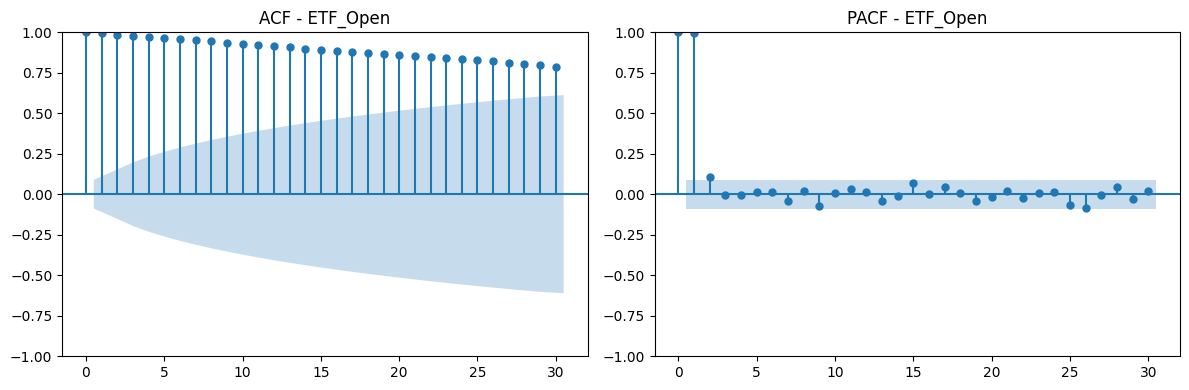

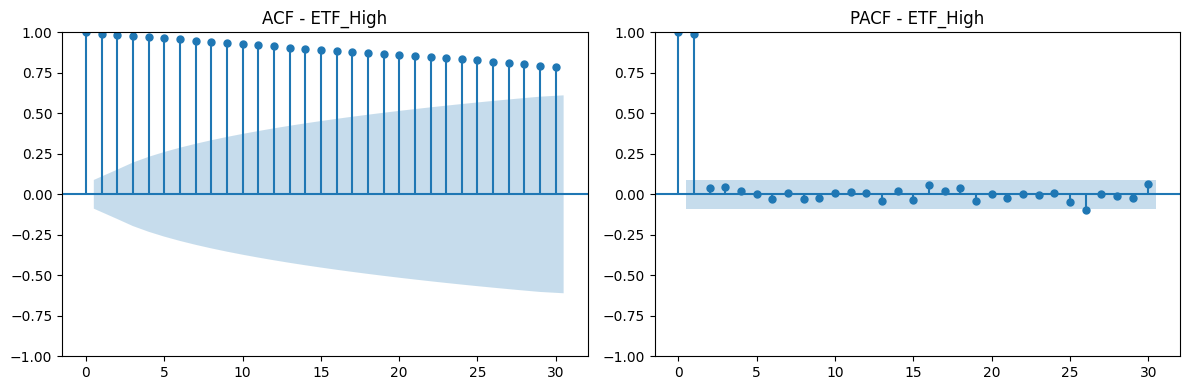

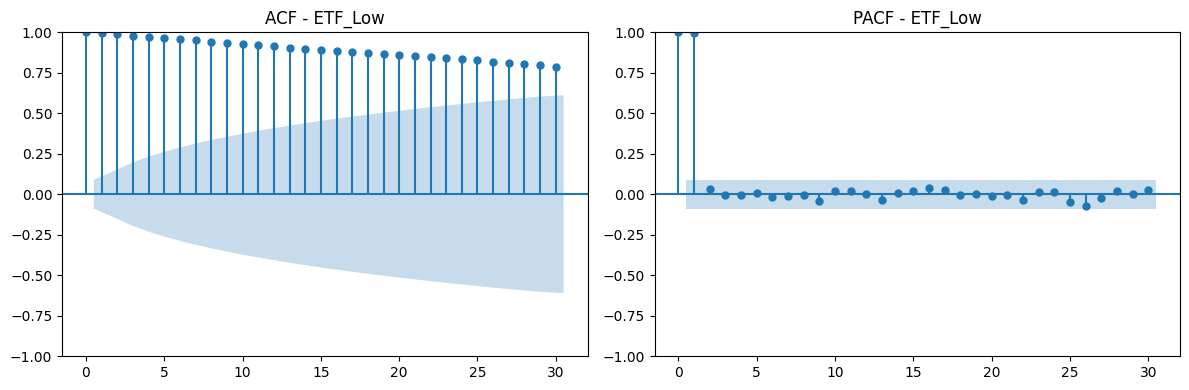

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Choose top 5 numeric columns
numerical_cols = data.select_dtypes(include="number").columns[:5]

# Plot ACF and PACF
for col in numerical_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(data[col].dropna(), lags=30, ax=ax[0])
    ax[0].set_title(f"ACF - {col}")
    plot_pacf(data[col].dropna(), lags=30, ax=ax[1])
    ax[1].set_title(f"PACF - {col}")
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
# Step 1: Select numeric columns (excluding date or non-feature columns)
numeric_cols = data.select_dtypes(include=[np.number]).columns
# Optionally exclude target if you don't want it lagged (remove if not needed)
exclude_cols = ['time_idx']  # or any others you want to exclude from lagging
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

# Step 2: Define lags to create
lags = [1,3, 7, 14]  # you can add more lags like 3, 14, etc.

# Step 3: Create lag features for each column
for col in feature_cols:
    for lag in lags:
        lag_col_name = f"{col}_lag{lag}"
        data[lag_col_name] = data[col].shift(lag)

In [ ]:
!pip install pykalman

In [ ]:
import numpy as np
from pykalman import KalmanFilter

# Step 1: Define Kalman smoothing function
def kalman_smooth_column(series):
    # Convert to numeric to handle any non-numeric strings
    series = pd.to_numeric(series)
    # Mask invalid (NaN/inf) values
    masked_series = np.ma.masked_invalid(series.values)
    # Initialize Kalman filter (ensure initial state is from a valid value)
    valid_init = series.dropna().iloc[0]
    kf = KalmanFilter(initial_state_mean=valid_init, n_dim_obs=1, n_dim_state=1)
    smoothed_state, _ = kf.smooth(masked_series)
    # Replace NaNs with smoothed values, keep original where valid
    return np.where(np.isnan(series.values), smoothed_state.flatten(), series.values)

# Step 2: List columns to smooth (all numeric columns with NaNs)
columns_to_smooth = data.select_dtypes(include=[np.number]).columns

# Step 3: Apply smoothing to each column and replace original with smoothed values
for col in columns_to_smooth:
    if data[col].isnull().any() or np.isinf(data[col]).any():
        print(f"Applying Kalman smoothing to: {col}")
        data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        data[col] = kalman_smooth_column(data[col])


Applying Kalman smoothing to: Gold_Open
Applying Kalman smoothing to: Gold_High


/tmp/ipython-input-67-1844289599.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].replace([np.inf, -np.inf], np.nan, inplace=True)


Applying Kalman smoothing to: Gold_Low
Applying Kalman smoothing to: Gold_Close
Applying Kalman smoothing to: Gold_Volume
Applying Kalman smoothing to: MF_NAV_lag1
Applying Kalman smoothing to: MF_NAV_lag3
Applying Kalman smoothing to: MF_NAV_lag7
Applying Kalman smoothing to: MF_NAV_lag14
Applying Kalman smoothing to: ETF_Price_lag1
Applying Kalman smoothing to: ETF_Price_lag3
Applying Kalman smoothing to: ETF_Price_lag7
Applying Kalman smoothing to: ETF_Price_lag14
Applying Kalman smoothing to: ETF_Open_lag1
Applying Kalman smoothing to: ETF_Open_lag3
Applying Kalman smoothing to: ETF_Open_lag7
Applying Kalman smoothing to: ETF_Open_lag14
Applying Kalman smoothing to: ETF_High_lag1
Applying Kalman smoothing to: ETF_High_lag3
Applying Kalman smoothing to: ETF_High_lag7
Applying Kalman smoothing to: ETF_High_lag14
Applying Kalman smoothing to: ETF_Low_lag1
Applying Kalman smoothing to: ETF_Low_lag3
Applying Kalman smoothing to: ETF_Low_lag7
Applying Kalman smoothing to: ETF_Low_lag14
A

In [ ]:
print("Missing values per column after kalman smoothing")
print(data.isna().sum())

Missing values per column after kalman smoothing
All_Date             0
MF_NAV               0
ETF_Price            0
ETF_Open             0
ETF_High             0
                    ..
Gold_Close_lag14     0
Gold_Volume_lag1     0
Gold_Volume_lag3     0
Gold_Volume_lag7     0
Gold_Volume_lag14    0
Length: 86, dtype: int64


In [ ]:
data['day_of_week'] = data['All_Date'].dt.weekday  # 0=Monday, 6=Sunday
data['month']       = data['All_Date'].dt.month

train = data[data.All_Date < '2024-01-01']
val   = data[(data.All_Date >= '2024-01-01') & (data.All_Date < '2024-10-01')]
test  = data[data.All_Date >= '2024-10-01']

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Add weekday feature (0=Mon,...,4=Fri) and one-hot encode
data['weekday'] = data['All_Date'].dt.weekday
data = pd.get_dummies(data, columns=['weekday'], prefix='wd')

# Create lag-1 NAV feature (shifted by 1 day)
data['MF_NAV_lag1'] = data['MF_NAV'].shift(1)

# Fill NaN values in MF_NAV_lag1 using Kalman smoothing
data['MF_NAV_lag1'] = kalman_smooth_column(data['MF_NAV_lag1'])


# Scale numeric features
#feature_cols = ['MF_NAV_lag1','ETF_Price','USD_Price','ETF_Low','ETF_High','ETF_Open','Gold_Open','Gold_Close']
feature_cols = [col for col in data.columns if col != 'MF_NAV' and col != 'All_Date']
scaler = StandardScaler().fit(data[feature_cols])
data[[col for col in data.columns if col != 'MF_NAV' and col != 'All_Date']] = scaler.transform(data[feature_cols])

# Our target is the (unscaled) MF_NAV of the current day
data['MF_NAV'] = kalman_smooth_column(data['MF_NAV'])  # Drop any remaining NaN (first row from lag)
print(data[[col for col in data.columns if col != 'MF_NAV' and col != 'All_Date']].head())

   ETF_Price  ETF_Open  ETF_High   ETF_Low   ETF_Vol  ETF_Change  USD_Price  \
0  -1.418551 -1.488415 -1.374239 -1.482149 -0.284563    0.637748  -0.458289   
1  -1.350111 -1.318844 -1.340673 -1.361001 -0.166868    1.079358  -0.421977   
2  -1.273116 -1.352758 -1.298717 -1.335040 -0.193109    1.217361  -0.588511   
3  -1.315891 -1.293408 -1.307108 -1.300426 -0.318753   -0.811282  -0.679917   
4  -1.350111 -1.276451 -1.298717 -1.343694 -0.247564   -0.673279  -1.053054   

   USD_Open  USD_High   USD_Low  ...  Gold_Volume_lag3  Gold_Volume_lag7  \
0 -0.570145 -0.557149 -0.574515  ...         -0.192837         -0.192748   
1 -0.534666 -0.244136 -0.459670  ...         -0.192823         -0.192739   
2 -0.432028 -0.400642 -0.443787  ...         -0.192808         -0.192731   
3 -0.481446 -0.546627 -0.738231  ...         -0.192793         -0.192722   
4 -0.653776 -0.576876 -0.922717  ...         -0.192852         -0.192713   

   Gold_Volume_lag14  day_of_week     month      wd_0      wd_1     

In [ ]:
# Define train/test split (last 89 days ~ 3 months for testing)
n_test = 89
train_df = data.iloc[:-n_test].reset_index(drop=True)
test_df  = data.iloc[-n_test:].reset_index(drop=True)

feature_cols_all = [col for col in data.columns if col != 'MF_NAV' and col != 'All_Date']
X_train = train_df[feature_cols_all].values.astype(np.float32)
y_train = train_df['MF_NAV'].values.astype(np.float32)  # target is MF_NAV (original scale)
X_test  = test_df[feature_cols_all].values.astype(np.float32)
y_test  = test_df['MF_NAV'].values.astype(np.float32)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_length=20):
        self.X = X
        self.y = y
        self.seq_length = seq_length
    def __len__(self):
        return len(self.X) - self.seq_length
    def __getitem__(self, idx):
        X_seq = self.X[idx:idx+self.seq_length]
        y_seq = self.y[idx+self.seq_length]
        return X_seq, y_seq

seq_length = 20
train_ds = TimeSeriesDataset(X_train, y_train, seq_length)
test_ds  = TimeSeriesDataset(X_test,  y_test,  seq_length)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=True)


In [ ]:
import torch.nn as nn

class LSTMForecast(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        # x shape: (batch, seq_length, input_dim)
        out, _ = self.lstm(x)         # out shape: (batch, seq_length, hidden_dim)
        out = out[:, -1, :]           # take last time step's output
        out = self.fc(out)            # shape: (batch, 1)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMForecast(input_dim=X_train.shape[1], hidden_dim=64, num_layers=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)


In [ ]:
epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Training MSE: {np.mean(train_losses):.6f}")


Epoch 10/50, Training MSE: 0.035485
Epoch 20/50, Training MSE: 0.022210
Epoch 30/50, Training MSE: 0.017095
Epoch 40/50, Training MSE: 0.014352
Epoch 50/50, Training MSE: 0.012459


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
preds_test = []
actuals_test = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)
        output = model(X_batch)
        preds_test.extend(output.cpu().numpy().flatten())
        actuals_test.extend(y_batch.cpu().numpy().flatten())

rmse = np.sqrt(mean_squared_error(actuals_test, preds_test))
mae  = mean_absolute_error(actuals_test, preds_test)
print(f"Test RMSE: {rmse:.4f}, Test MAE: {mae:.4f}")


Test RMSE: 0.9975, Test MAE: 0.9680


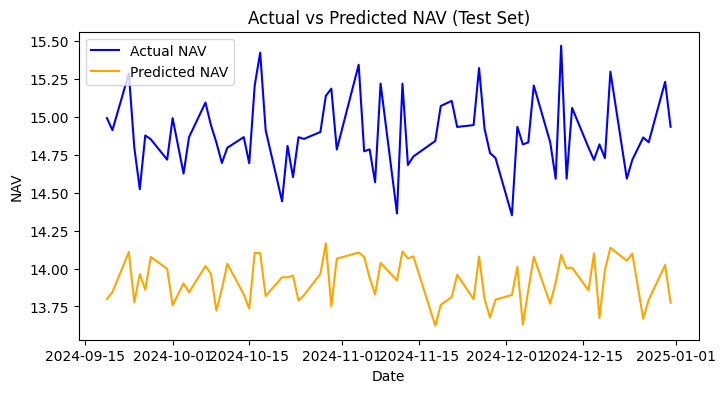

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(test_df['All_Date'][seq_length:].values, actuals_test, label='Actual NAV', color='blue')
plt.plot(test_df['All_Date'][seq_length:].values, preds_test,  label='Predicted NAV', color='orange')
plt.xlabel('Date'); plt.ylabel('NAV'); plt.title('Actual vs Predicted NAV (Test Set)')
plt.legend(); plt.show()


In [ ]:
print("Actual Test Values",actuals_test)
print("\n--- Predicted Test Values:----",preds_test)

Actual Test Values [np.float32(14.9931), np.float32(14.9136), np.float32(15.2885), np.float32(14.7981), np.float32(14.5237), np.float32(14.8785), np.float32(14.8538), np.float32(14.7188), np.float32(14.9929), np.float32(14.6269), np.float32(14.8673), np.float32(15.0956), np.float32(14.9469), np.float32(14.832), np.float32(14.697), np.float32(14.7974), np.float32(14.8675), np.float32(14.695), np.float32(15.2087), np.float32(15.4253), np.float32(14.9136), np.float32(14.4439), np.float32(14.8097), np.float32(14.6036), np.float32(14.867), np.float32(14.8557), np.float32(14.9012), np.float32(15.1402), np.float32(15.1874), np.float32(14.7857), np.float32(15.3453), np.float32(14.7741), np.float32(14.7868), np.float32(14.5695), np.float32(15.2212), np.float32(14.3638), np.float32(15.2205), np.float32(14.6835), np.float32(14.7399), np.float32(14.8421), np.float32(15.073), np.float32(15.1072), np.float32(14.9347), np.float32(14.9471), np.float32(15.3237), np.float32(14.9241), np.float32(14.7623)